In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import timeit
from arch.bootstrap import CircularBlockBootstrap, optimal_block_length
import pickle
import numpy as np
import pandas as pdw
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from math import log
from scipy.stats import boxcox
from os import getenv, path
from pathlib import Path
from sys import getsizeof
import sys
import timeit
import seaborn as sns
from itertools import chain

In [351]:
# dynamically deciding login info 
# then login to wrds
def pgpass_dir():
    if sys.platform.startswith('win'):
        os_path = getenv('LOCALAPPDATA')
        file_path = os_path+'\postgresql\pgpass.conf'
        print (file_path)
    elif sys.platform.startswith('darwin'):
        #* can be replaced by your laptop's name
        #in order to boost searching performance
        if path.exists('/Users/*/.pgpass'):
            file_path = '/Users/*/.pgpass'
        else:
            dir_path = os.path.dirname('/Users/')
            keyword = '.pgpass'
            for root, dirs, files in os.walk(dir_path):
                for file in files:
                    if keyword in file:
                        file_path = root+'/'+str(file)
    return file_path

In [48]:
file_path = pgpass_dir()
#read login info and pass connection parameters
with open(file_path,'r') as f:
    output = f.read()
    
    login_id = output.split(":")[3]
    crsp_db = wrds.Connection(wrds_username=login_id)

C:\Users\justi\AppData\Local\postgresql\pgpass.conf
Enter your WRDS username [justi]:justinbooms
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.


Exception during reset or similar
Traceback (most recent call last):
  File "C:\Users\justi\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "C:\Users\justi\Anaconda3\lib\site-packages\sqlalchemy\pool\base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "C:\Users\justi\Anaconda3\lib\site-packages\sqlalchemy\engine\default.py", line 531, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



Loading library list...
Done


In [49]:
#combine login into one function
#in order to keep timeout away
#issue : too many connections to server 
# not in use
def re_conn_wrds():
    file_path = pgpass_dir()
    #read login info and pass connection parameters
    with open(file_path,'r') as f:
        output = f.read()
        login_id = output.split(":")[3]
        crsp_db = wrds.Connection(wrds_username=login_id)

In [50]:
#retrieved cooresponding permno 
#criterion : the latest valid date
def data_generator(num=3, ticker_name=tuple(['GLD','SPY','TLT'])):
    ticker_list = {'tickers': tuple(ticker_name)}
    permno_list_init = crsp_db.raw_sql('SELECT a.permno FROM crsp.stocknames a, (SELECT distinct(max(nameenddt)) as date_time FROM crsp.stocknames WHERE ticker in %(tickers)s group by ticker) as b WHERE a.ticker in %(tickers)s and a.nameenddt = b.date_time group by a.permno', params=ticker_list)
    #generate tuple for permno
    permno_list_tuple = tuple(permno_list_init.permno.astype(str).values.tolist())
    permno_list = {'permno': permno_list_tuple}
    #generate data
    final_data = crsp_db.raw_sql('select distinct b.ticker, a.date, a.prc, a.ret from crspm.dsf a, crsp.stocknames b, \
    (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c \
where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc', params=permno_list,date_cols=['date'])
    return final_data

In [ ]:
#generate vix data from cboe database
#vix data is from database : cboe and table : cboe
def vix_generator(self):
    vix_index = crsp_db.raw_sql('SELECT date,vix FROM cboe.cboe where vix is not NULL')
    return vix_index

In [51]:
#generate dataframe and pickle file
def input_ticker():
    number_stock = int(input("Please enter your number of stocks, e.g 3,4,5: ").strip())
    ticker_name = []
    init_weight = []
    total_weight = 1
    temp_weight = 0
    [ticker_name.append(input("Please enter one ticker each time, e.g spy, tlt, gld: ").strip().upper()) for i in range(number_stock)]
    for i in ticker_name:
        temp_i = float(input("Please enter weight for {0}. The number should be less than or equal to 10".format(i)))/10
        while temp_i > total_weight:
            temp_i = float(input("The percentage of {0} is greater than 100%, Please re-enter weight for {0}".format(i)))/10
        init_weight.append(temp_i)
        while sum(init_weight) > total_weight:
            init_weight.remove(temp_i)
            temp_i = float(input("Please re-enter weight for {0}, because of total amount is greather than 100%".format(i)))/10
            init_weight.append(temp_i)
    p_weight = dict(zip(ticker_name, init_weight))
    final_data = data_generator(number_stock,ticker_name)
    final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
    final_data_pivot = final_data_pivot.dropna()
    final_data_pivot.to_pickle('dummy_data.pkl')
    #generate vix data
    vix_data = vix_generator(vix_generator)
    vix_data.to_pickle('vix_data.pkl')
    return final_data_pivot, p_weight, vix_data

In [52]:
#new function for loading bulky tickers
def bulky_import(path_location):
    ticker_name = []
    init_weight = []
    total_weight = 1
    if path.exists(path_location):
        with open(path_location) as temp_file:
            for line in temp_file:
                ticker_1, number_1 = line.rstrip().split(',')
                ticker_name.append(ticker_1.upper())
                init_weight.append(number_1)
            weight = list(map(float,init_weight))
        if (sum(weight))/10 > total_weight:
            return (print ("The total percentage is greather than 100%, please check import file")),''
        else:
            p_weight = dict(zip(ticker_name,weight))
            final_data = data_generator(len(ticker_name), ticker_name)
            final_data_pivot = pd.pivot_table(final_data, index=['date'],columns='ticker').stack(level=-2).unstack(level=-1)
            final_data_pivot = final_data_pivot.dropna()
            final_data_pivot.to_pickle('dummy_data.pkl')
            #generate vix data
            vix_data = vix_generator(vix_generator)
            vix_data.to_pickle('vix_data.pkl')
            return final_data_pivot, p_weight, vix_data
    else:
        return (print("File do not exist!")),''

In [ ]:
#bulky load from local file
#can be escaped when test
final_data_pivot, p_weight , vix_data= bulky_import(r'/Volumes/backup/MSCA31001 Reserch Desgin/Capstone_TDAmeritrade/all_tickers.txt')

In [59]:
final_data_pivot

Please enter your number of stocks, e.g 3,4,5: 1
Please enter one ticker each time, e.g spy, tlt, gld: ^vix
Please enter weight for ^VIX10


ProgrammingError: (psycopg2.errors.SyntaxError) syntax error at or near ")"
LINE 1: ...rmno) as min_date from crspm.dsf where permno in ()) temp) a...
                                                             ^

[SQL: select distinct b.ticker, a.date, a.prc, a.ret from crspm.dsf a, crsp.stocknames b,     (select max(min_date) as start_time from (select distinct permno, min(date) over (partition by permno) as min_date from crspm.dsf where permno in %(permno)s) temp) as c where a.permno in %(permno)s and a.permno = b.permno and a.date >= c.start_time order by 1,2,3 asc]
[parameters: {'permno': ()}]
(Background on this error at: http://sqlalche.me/e/f405)

In [58]:
p_weight

ticker        VLOG                VX          
               prc       ret     prc       ret
date                                          
1999-02-08  5.3750       NaN  5.3750       NaN
1999-02-09  5.3750  0.000000  5.3750  0.000000
1999-02-10  6.1875  0.151163  6.1875  0.151163
1999-02-11  5.7500 -0.070707  5.7500 -0.070707
1999-02-12  5.3125 -0.076087  5.3125 -0.076087
...            ...       ...     ...       ...
2001-04-19  6.6000  0.157895  6.6000  0.157895
2001-04-20  6.4500 -0.022727  6.4500 -0.022727
2001-04-23  6.3600 -0.013953  6.3600 -0.013953
2001-04-24  6.5500  0.029874  6.5500  0.029874
2001-04-25  6.6500  0.015267  6.6500  0.015267

[559 rows x 4 columns]

In [4]:
final_data_pivot, p_weight = input_ticker()

NameError: name 'input_ticker' is not defined

In [5]:
final_data_pivot

NameError: name 'final_data_pivot' is not defined

In [2]:
with open('vix_data.pkl', 'rb') as f: dummy_data = pickle.load(f)
vix = dummy_data.iloc[-4035:]
vix

,date,vix
3752,2004-11-19,13.50
3753,2004-11-22,12.97
3754,2004-11-23,12.67
3755,2004-11-24,12.72
3756,2004-11-26,12.78
...,...,...
7782,2020-11-23,22.66
7783,2020-11-24,21.64
7784,2020-11-25,21.25
7785,2020-11-27,20.84


In [2]:
with open('low_var_port.pkl', 'rb') as f: data = pickle.load(f)
data = data.iloc[:,[1,5,9]]
data.iloc[0] = [1,1,1]
portfolio_weights = {'SPY':.5, 'TLT': .4, 'GLD': .1}
initial_money = 1000000
rebalance_days = 4500
threshold = .05

In [129]:
data_raw = data.to_numpy()
data_df = pd.DataFrame(data_raw)
test = data_df.cumprod()


In [151]:
returns_annual = (test.iloc[-1:].values)**(253/np.shape(data_df)[0])
returns_annual.tolist()

AttributeError: 'float' object has no attribute 'tolist'

In [144]:
test.iloc[-1:]

,0,1,2
4034,4.246754,3.077873,3.721974


In [133]:

returns_daily = data_df-1
returns_annual = returns_daily.mean() * 253

In [152]:
returns_annual.shape

(1, 3)

In [171]:
def Efficient_Frontier_Port_Const(data_ret, portfolio_weights_raw):
    data_raw = data_ret.to_numpy()
    data_df = pd.DataFrame(data_raw)
    selected = [*portfolio_weights_raw]
    data_headers = [*portfolio_weights_raw]
    data_df.columns = data_headers
    
    returns_daily = data_df-1
    returns_annual_1 = data_df.cumprod()
    returns_annual_2 = (returns_annual_1.iloc[-1:].values)**(253/np.shape(data_df)[0])
    returns_annual = returns_annual_2.ravel()
    #returns_annual = returns_daily.mean() * 253
    cov_daily = returns_daily.cov()
    cov_annual = cov_daily * 253

    port_returns = []
    port_volatility = []
    stock_weights = []
    sharpe_ratio = []
    stock_weights = []

    # set the number of combinations for imaginary portfolios
    num_assets = len(selected)
    num_portfolios = 50000

    # populate the empty lists with each portfolios returns,risk and weights
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, returns_annual)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
        sharpe = returns / volatility
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)

    # a dictionary for Returns and Risk values of each portfolio
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility,
                 'Sharpe Ratio': sharpe_ratio}

    # extend original dictionary to accomodate each ticker and weight in the portfolio
    for counter,symbol in enumerate(selected):
        portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

    # make a nice dataframe of the extended dictionary
    df = pd.DataFrame(portfolio)

    # get better labels for desired arrangement of columns
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

    # reorder dataframe columns
    #df = df[column_order]

    # find min Volatility & max sharpe values in the dataframe (df)
    min_volatility = df['Volatility'].min()
    max_sharpe = df['Sharpe Ratio'].max()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
    min_variance_port = df.loc[df['Volatility'] == min_volatility]

    weight_min_var = min_variance_port.to_numpy() 
    weight_min_var = list(chain(*weight_min_var))
    weight_min_var = np.delete(weight_min_var,[0,1,2],0) 
    portfolio_weights_min_var = dict(zip(selected, weight_min_var))

    weight_sharpe = sharpe_portfolio.to_numpy()
    weight_sharpe = list(chain(*weight_sharpe))
    weight_sharpe = np.delete(weight_sharpe,[0,1,2],0)
    portfolio_weights_sharpe = dict(zip(selected, weight_sharpe))

    # plot frontier, max sharpe & min Volatility values with a scatterplot
    plt.style.use('seaborn-dark')
    df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.show()
    return portfolio_weights_min_var,portfolio_weights_sharpe


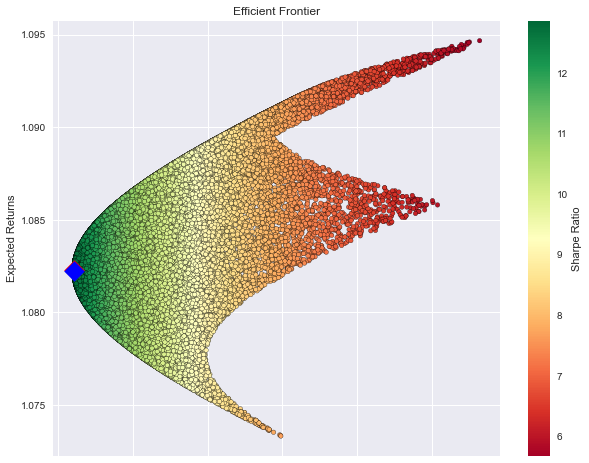

In [172]:
a,b = Efficient_Frontier_Port_Const(data, portfolio_weights)

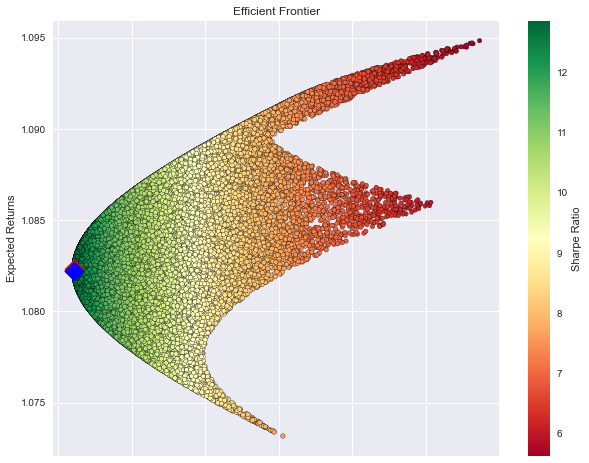

In [170]:
data_raw = data.to_numpy()
data_df = pd.DataFrame(data_raw)
selected = [*portfolio_weights]
data_headers = [*portfolio_weights]
data_df.columns = data_headers

returns_daily = data_df-1
returns_annual_1 = data_df.cumprod()
returns_annual_2 = (returns_annual_1.iloc[-1:].values)**(253/np.shape(data_df)[0])
returns_annual = returns_annual_2.ravel()
#returns_annual = returns_daily.mean() * 253
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 253

port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
#df = df[column_order]

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

weight_min_var = min_variance_port.to_numpy() 
weight_min_var = list(chain(*weight_min_var))
weight_min_var = np.delete(weight_min_var,[0,1,2],0) 
portfolio_weights_min_var = dict(zip(selected, weight_min_var))

weight_sharpe = sharpe_portfolio.to_numpy()
weight_sharpe = list(chain(*weight_sharpe))
weight_sharpe = np.delete(weight_sharpe,[0,1,2],0)
portfolio_weights_sharpe = dict(zip(selected, weight_sharpe))

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
    

In [165]:
returns_annual_1 = data_df.cumprod()
returns_annual_2 = (returns_annual_1.iloc[-1:].values)**(253/np.shape(data_df)[0])
returns_annual = returns_annual_2.ravel()

In [168]:
returns_annual.shape

(3,)

In [101]:
portfolio_weights_min_var

{'SPY': 0.336988216982931,
 'TLT': 0.5182085868964289,
 'GLD': 0.14480319612064002}

In [102]:
portfolio_weights_sharpe

{'SPY': 0.3599149073517063,
 'TLT': 0.48158259540804654,
 'GLD': 0.15850249724024715}

In [93]:
weight_min_var = np.delete(weight_min_var,[0,1,2],0) 

IndexError: index 1 is out of bounds for axis 0 with size 1

In [88]:


test = np.delete(weight_sharpe,[0,1,2],0)
test

array([0.35860029, 0.48183191, 0.1595678 ])

In [4]:
#Simulating the daily returns for each of the assets within the portfolio
def sim_returns(data, random_seed=None,block_size = 20, total_sim = 10):
    ret_index = [x for x, y in enumerate(data.columns) if y[1] == 'ret']
    ret_sim = data.iloc[:,ret_index].to_numpy()
    rs = np.random.RandomState(random_seed)
    ret_sim_mod = CircularBlockBootstrap(block_size, ret_sim, random_state = rs)
    col = ret_sim.shape[1]
    sim = np.zeros((total_sim,len(data), col))
    count = 0
    for y in ret_sim_mod.bootstrap(total_sim):
        sim[count,:,:] = y[0][0]
        count +=1
    return sim

In [7]:
sim_returns(data, random_seed=3,block_size = 20, total_sim = 10)

array([[[1.00757222, 0.98662334, 0.99885578],
        [1.02246838, 0.98001571, 1.00044551],
        [1.00060621, 1.00151935, 0.98276187],
        ...,
        [1.00228967, 1.01243724, 0.99636296],
        [1.01219984, 0.99504049, 0.98861466],
        [0.99126047, 1.00214707, 0.99920882]],

       [[1.00233613, 1.00386342, 1.00367975],
        [1.00004093, 0.99937165, 1.01588728],
        [1.00114486, 1.00322229, 0.9978346 ],
        ...,
        [1.01593934, 1.00888206, 0.99873315],
        [1.01161226, 1.00033862, 1.00245757],
        [0.98751349, 0.99856141, 0.98956109]],

       [[1.00554682, 0.99746886, 1.01105192],
        [0.9996214 , 1.00892854, 1.00170557],
        [1.00005415, 1.00530973, 0.99148668],
        ...,
        [1.02013188, 0.99399316, 1.01969484],
        [0.9999138 , 1.01256592, 1.00625996],
        [0.99879342, 0.99166354, 0.98907517]],

       ...,

       [[1.01327518, 0.9923347 , 1.00535816],
        [1.00362396, 1.00268212, 1.01022117],
        [1.01549783, 0

In [8]:
def val_pul(ls, i):
    return ls[i]

In [9]:
def ret_rebalance(data,portfolio_weights, initial_money = 1000000, rebalance_days = 20, threshold = 10):
    
    arr_data = np.array(data)

    arr_port_det = np.zeros([data.shape[0], data.shape[1]*3]) #Need to change back to data
    arr_port_sum = np.zeros([data.shape[0], 1])
    arr_port_ret = np.zeros([data.shape[0], 1]) #Need to change back to data
    arr_portfolio_weights = np.array([i for i in portfolio_weights.values()])

    #This loop goes through the data set "d", which should be a daily time series of asset returns and prices.
    #Returns should be broken into returns including dividends, returns without dividends, and dividend only returns. 

    arr_data = np.array(data)
    cum_ret_2 = np.cumprod(arr_data, axis=0)

    #Since the cum_ret_2 keeps track of the cumulative returns and when we rebalance, the cumulative return
    #needs to be reset to 1, so create an array to keep track the cumulative returns right before rebalancing,
    #and this will be used to reset the cumulative returns.

    cum_ret_tracking = np.zeros(data.shape[1])
    cum_ret_tracking[:]=1

    trading_day_counter=1
    count = 0
    initial_arr_asset_val = initial_money*arr_portfolio_weights
    num_assets = cum_ret_2.shape[1]
    
    for row in cum_ret_2:
        tradeflag = 0
        arr_latest_ret = row
        cur_asset_val = initial_arr_asset_val * arr_latest_ret/cum_ret_tracking
        
        total_value = sum(cur_asset_val)
        
        
        arr_actual_weights = cur_asset_val/total_value
        dev_weights = np.absolute((arr_actual_weights/arr_portfolio_weights)-1)
        
        if trading_day_counter % rebalance_days == 0 or np.amax(dev_weights) > threshold:
           
            
            tradeflag = 1
            cum_ret_tracking = arr_latest_ret

            arr_new_port_det = np.array([], dtype='f8')
          
            cur_asset_val = total_value*arr_portfolio_weights
      
            initial_arr_asset_val = cur_asset_val
            trading_day_counter=1
            
            #end_time1 = timeit.default_timer()-start_time1
            #print('1 '+str(end_time1))
        else:
            trading_day_counter += 1    
        #Reaggregates all the data into the dataframe "portfolio_detail" and "portfolio_sum"

        
      
        test = [[row[[i]], arr_actual_weights[i], cur_asset_val[i]] for i in range(num_assets)]
        test2 = [item for regularlist in test for item in regularlist]
        arr_port_det[count] = test2

        

        if count == 0:
            arr_port_ret[count] = 0
        else:
            arr_port_ret[count] = [(total_value/arr_port_sum[count-1])-1]
        arr_port_sum[count] = [total_value]
        tradeflag = 0
        count += 1
        
        
    return arr_port_sum, arr_port_det, arr_port_ret

In [111]:
start_time1=timeit.default_timer()
a,b,c = ret_rebalance(data,portfolio_weights, initial_money = 1000000, rebalance_days = 1, threshold = 10)
end_time1 = timeit.default_timer()-start_time1


## Evaluation code

In [363]:
total_sim = 100
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(data), sum_col))
arr_ret_value = np.zeros((total_sim,len(data), sum_col))
arr_det_value = np.zeros((total_sim,len(data), det_col))
arr_ann_ret_nb = np.zeros((total_sim, 1))
arr_std_ret_nb = np.zeros((total_sim, 1))
counter = 0
ls_rebal_day = [1,21,63,126,253,400000]
ls_threshold = [.01,.05,.1,.2,.25,1000]
ls_performance = []
for d in ls_rebal_day:
    for t in ls_threshold:
        for x in range(total_sim):

            bootstrap = sim_returns(data,block_size = 20, total_sim = 1, random_seed = x)

            bootstrap[0][0] = [1,1,1]

            arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(bootstrap[0],portfolio_weights, initial_money = 1, rebalance_days = d, threshold = t)

            
            arr_sum_value[x] = arr_port_sum
            arr_det_value[x] = arr_port_det
            arr_ret_value[x] = arr_port_ret
    
        counter +=1
        
        for x in range(total_sim):
            arr_ann_ret_nb[x] =  arr_sum_value[x][-1]**(1/years)-1
            arr_std_ret_nb[x] = np.std(arr_ret_value[x])*(trading_days_per_year**.5)
        
        
        ls_performance.append([d,t,np.mean(arr_ann_ret_nb),np.mean(arr_std_ret_nb)])

In [365]:
df_performance = pd.DataFrame(ls_performance, columns = ['rebal_days', 'threshold', 'ann_ret', 'daily_var'])
df_performance['ann_std'] = df_performance['daily_var']**(.5)*(253**(.5))
df_performance

In [114]:
with open('df_performance.pkl', 'rb') as f: df_performance = pickle.load(f)

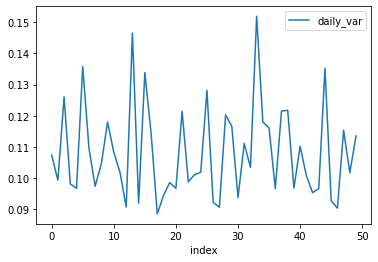

In [115]:
df = pd.DataFrame (arr_std_ret_nb,columns=['daily_var'])
df.reset_index().plot(x ='index', y='daily_var', kind = 'line')
plt.show()

In [118]:
"""# bigger plot elements suitable for giving talks
sns.set_context("talk")
# set figure size
plt.figure(figsize=(9,6))
# Time series plot with Seaborn lineplot()
sns.lineplot(x="date", y="positiveIncrease", 
            data=corona_ny, ci=None)
# axis labels
plt.xlabel("Date", size=14)
plt.ylabel("Daily New Cases", size=14)
# save image as PNG file
plt.savefig("Time_Series_Plot_with_Seaborn.png",
                    format='png',
                    dpi=150)"""

NameError: name 'corona_ny' is not defined

<Figure size 648x432 with 0 Axes>

In [367]:
df_performance.to_pickle('df_performance.pkl')

In [119]:

by_threshd_result = df_performance[df_performance['rebal_days']==max(ls_rebal_day)]
by_threshd_result = by_threshd_result[by_threshd_result['threshold']!=max(ls_threshold)]

del by_threshd_result['rebal_days']
by_threshd_result['threshold'] = by_threshd_result['threshold'].astype(float).map("{:.0%}".format)
by_threshd_result['ann_ret'] = by_threshd_result['ann_ret'].astype(float).map("{:.2%}".format)
by_threshd_result['daily_var'] = by_threshd_result['daily_var'].astype(float).map("{:.2%}".format)
by_threshd_result['ann_std'] = by_threshd_result['ann_std'].astype(float).map("{:.2%}".format)

In [120]:
by_timep_result = df_performance[df_performance['rebal_days']!=max(ls_rebal_day)]
by_timep_result = by_timep_result[by_timep_result['threshold']==max(ls_threshold)]

del by_timep_result['threshold']
by_timep_result['ann_ret'] = by_timep_result['ann_ret'].astype(float).map("{:.2%}".format)
by_timep_result['daily_var'] = by_timep_result['daily_var'].astype(float).map("{:.2%}".format)
by_timep_result['ann_std'] = by_timep_result['ann_std'].astype(float).map("{:.2%}".format)

In [121]:
import six
def render_mpl_table(data, col_width=10.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1.5, 1.5], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,cellLoc='center', **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

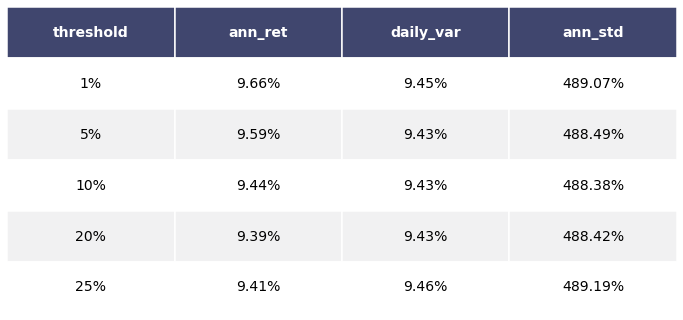

In [122]:
render_mpl_table(by_threshd_result, header_columns=0, col_width=2.0)

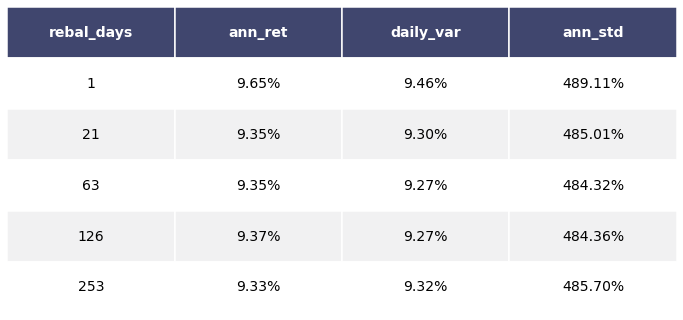

In [123]:
render_mpl_table(by_timep_result, header_columns=0, col_width=2.0)

## High Variance Cases

#### Simulating cases with vix price data added.

In [10]:
with open('vix_data.pkl', 'rb') as f: dummy_data = pickle.load(f)
vix = dummy_data.iloc[-4035:]

df_hvar = data
df_hvar[('vix','ret')] = list(vix['vix'])
df_hvar

ticker,SPY,TLT,GLD,vix
metric,ret,ret,ret,ret
date,,,,
2004-11-19,1.000000,1.000000,1.000000,13.50
2004-11-22,1.004769,1.005212,1.003796,12.97
2004-11-23,1.001526,1.001240,0.995551,12.67
2004-11-24,1.002370,1.000000,1.006704,12.72
2004-11-26,0.999156,0.993471,1.005327,12.78
...,...,...,...,...
2020-11-23,1.005994,0.995418,0.980306,22.66
2020-11-24,1.016114,0.990048,0.984672,21.64


In [12]:
bootstrap = sim_returns(df_hvar,block_size = 20, total_sim = 1000, random_seed = 5)

In [38]:
ls_avgvix = []
for x in bootstrap:
    avgvix = np.mean(x[:,3])
    ls_avgvix.append(avgvix)


In [39]:
df_avgvix = pd.DataFrame(ls_avgvix, columns = ['avg_vix'])

#### Taking simulations >75th percentile of vix price.

In [40]:
df_vix_75 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.75)[0]]

In [41]:
ls_high_var_75 = []
for x in list(df_vix_75.index):
    ls_high_var_75.append(bootstrap[x][:,0:3])


#### Taking simulations >75th percentile of vix price.

In [43]:
df_vix_95 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.95)[0]]

ls_high_var_95 = []
for x in list(df_vix_95.index):
    ls_high_var_95.append(bootstrap[x][:,0:3])


In [83]:
y = ls_high_var_95[2]
y[0]=[1,1,1]
y

array([[1.        , 1.        , 1.        ],
       [0.9954119 , 0.98702991, 0.98913206],
       [1.00581798, 1.00692761, 0.99339273],
       ...,
       [1.00754442, 1.00643749, 0.9729034 ],
       [1.0048634 , 1.00867306, 0.97832387],
       [0.98632558, 1.00397681, 1.01507157]])

In [94]:
total_sim = len(ls_high_var_95)
sum_col = 1
det_col = 9
trading_days_per_year = 253
trade_days = 4035
years = trade_days/trading_days_per_year

arr_sum_value = np.zeros((total_sim,len(data), sum_col))
arr_ret_value = np.zeros((total_sim,len(data), sum_col))
arr_det_value = np.zeros((total_sim,len(data), det_col))
arr_ann_ret_nb = np.zeros((total_sim, 1))
arr_std_ret_nb = np.zeros((total_sim, 1))
counter = 0
ls_rebal_day = [1,21,63,126,253,400000]
ls_threshold = [.01,.05,.1,.2,.25,1000]
ls_performance_95 = []
for d in ls_rebal_day:
    for t in ls_threshold:
        for x in range(len(ls_high_var_95)):

            sim = ls_high_var_95[x]
            sim[0] = [1,1,1]

            arr_port_sum, arr_port_det,arr_port_ret  = ret_rebalance(sim,portfolio_weights, initial_money = 1, rebalance_days = d, threshold = t)
            
            arr_sum_value[x] = arr_port_sum
            arr_det_value[x] = arr_port_det
            arr_ret_value[x] = arr_port_ret
    
        counter +=1
        
        for x in range(total_sim):
            arr_ann_ret_nb[x] =  arr_sum_value[x][-1]**(1/years)-1
            arr_std_ret_nb[x] = np.std(arr_ret_value[x])*(trading_days_per_year**.5)
        
        
        ls_performance_95.append([d,t,np.mean(arr_ann_ret_nb),np.mean(arr_std_ret_nb)])

In [95]:
df_performance_95 = pd.DataFrame(ls_performance_95, columns = ['rebal_days', 'threshold', 'ann_ret', 'mean_ann_std', 'std_ann_ret'])
df_performance_95['ann_std'] = df_performance_95['daily_var']**(.5)*(253**(.5))
df_performance_95

,rebal_days,threshold,ann_ret,daily_var,ann_std
0,1,0.01,0.092829,0.104112,5.132280
1,1,0.05,0.092829,0.104112,5.132280
2,1,0.10,0.092829,0.104112,5.132280
3,1,0.20,0.092829,0.104112,5.132280
4,1,0.25,0.092829,0.104112,5.132280
5,1,1000.00,0.092829,0.104112,5.132280
6,21,0.01,0.092861,0.104097,5.131904
7,21,0.05,0.092082,0.103794,5.124434
8,21,0.10,0.089823,0.103551,5.118432
9,21,0.20,0.089070,0.102360,5.088926


In [89]:
df_performance_95.to_pickle('df_performance_95.pkl')

In [49]:
ls_cumret = []

for x in bootstrap:
    port = x[:,0:3]
    port[0] = [1,1,1]
    cumret = np.cumprod(port, axis = 0)
    cumret = cumret*np.array([.5,.4,.1])
    cumret = np.sum(cumret, axis = 1)
    ls_cumret.append(cumret)

In [48]:
np.sum(cumret, axis = 1)

array([1.        , 0.99928696, 0.99734182, ..., 4.0432417 , 4.05197498,
       4.02518802])

In [29]:
x[:,0:3]

array([[1.00283857, 0.99537858, 0.98076453],
       [0.99836885, 1.00164746, 1.00049657],
       [1.01302254, 0.98856161, 0.99346567],
       ...,
       [1.00319406, 0.9830598 , 1.01173143],
       [0.98736399, 1.00413275, 0.99104356],
       [1.00964599, 0.99108864, 0.99628823]])

In [45]:
ls_cumret[]

array([[0.5       , 0.4       , 0.1       ],
       [0.5010722 , 0.39649279, 0.10172198],
       [0.49477318, 0.40079674, 0.1017719 ],
       ...,
       [0.81289248, 2.83058986, 0.39975937],
       [0.81044563, 2.84099389, 0.40053547],
       [0.80887065, 2.81687549, 0.39944189]])

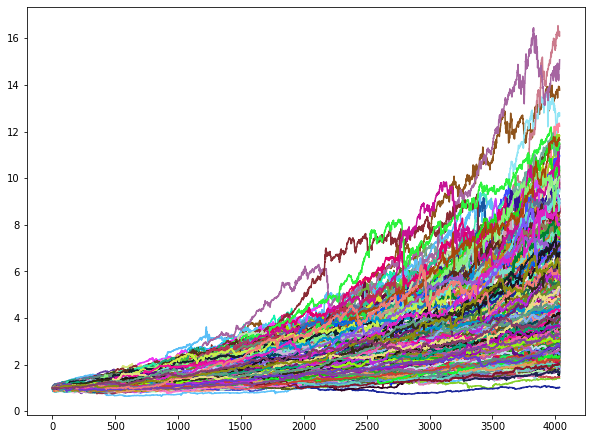

In [50]:
import random

b = list(range(4035))
a = ls_cumret #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

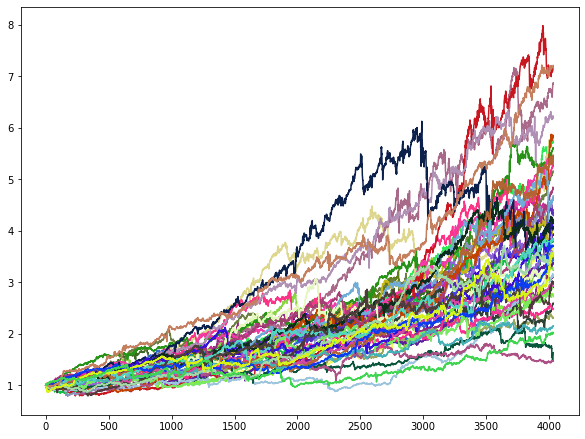

In [55]:
b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_95.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

In [57]:
df_vix_99 = df_avgvix[df_avgvix['avg_vix']>df_avgvix.quantile(q=.99)[0]]

ls_high_var_99 = []
for x in list(df_vix_99.index):
    ls_high_var_99.append(bootstrap[x][:,0:3])

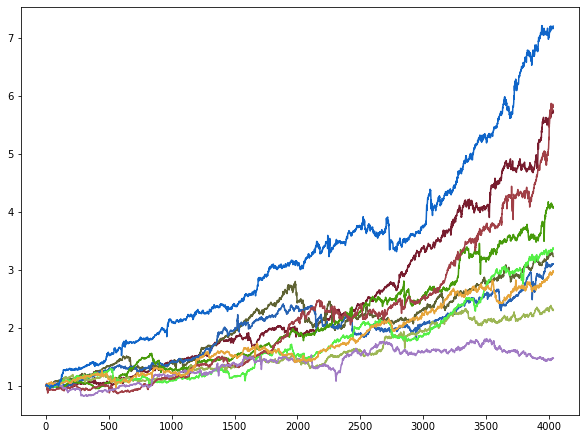

In [58]:
b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_95.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)

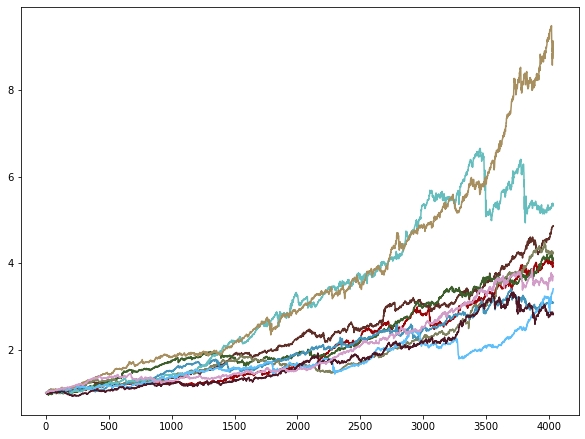

In [59]:
df_vix_01 = df_avgvix[df_avgvix['avg_vix']<df_avgvix.quantile(q=.01)[0]]


b = list(range(4035))
a = [ls_cumret[i] for i in list(df_vix_01.index)] #[ls_cumret[i][:,0] for i in range(len(cumret))]


rand = lambda: random.randint(0, 255)
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)
for ydata in a:
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    plot, = ax.plot(b, ydata, color=clr)